In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [31]:
#df=pd.read_csv('./wfData/waveform_template.csv',index_col='time_ns')
#df=pd.read_csv('./wfData/waveform_template_fast_25um_lee.csv',index_col='time_ns')
df=pd.read_csv('./wfData/waveform_template_fast_25um_lee_conv.csv',index_col='time_ns')
#df=pd.read_csv('./wfData/waveform_template_fast_35um_lee.csv',index_col='time_ns')
df_sig = df.copy()
#df['time_s']=df.index/1.0e9
#df.set_index('time_s',inplace=True)
sig_time_window_width = (df_sig.index[-1]-df_sig.index[0])
charge=float(df_sig.sum()*sig_time_window_width)

In [3]:
!head ./wfData/NUVHD25um.txt

#time (s) normalized amplitude
0.000000000e+00 0.000000000e+00
2.000000000e-10 6.666666667e-02
4.000000000e-10 1.333333333e-01
6.000000000e-10 2.000000000e-01
8.000000000e-10 2.666666667e-01
1.000000000e-09 3.333333333e-01
1.200000000e-09 4.000000000e-01
1.400000000e-09 4.666666667e-01
1.600000000e-09 5.333333333e-01


In [4]:
df_a_25um=pd.read_csv('./wfData/NUVHD25um.txt', header=None, comment='#', delim_whitespace='\t',
                      names=['time_s','ampl'], index_col='time_s')
df_a_35um=pd.read_csv('./wfData/NUVHD35um.txt', header=None, comment='#', delim_whitespace='\t',
                      names=['time_s','ampl'], index_col='time_s')
#df_a.plot(xlim=(0,5*1.0e-9))

(490.0, 710.0)

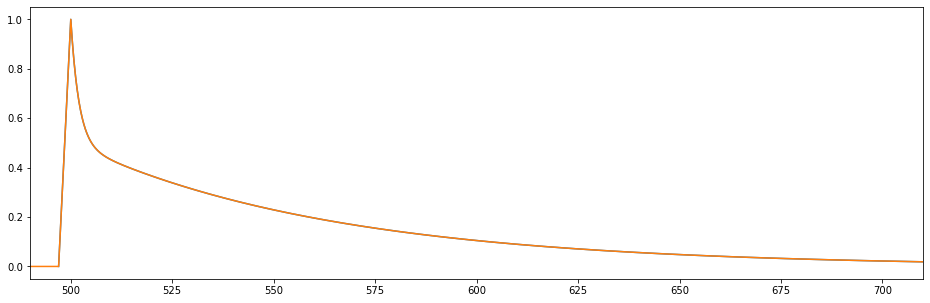

In [5]:
fig, ax1 = plt.subplots(figsize=(16,5))
ax1.plot(df_a_25um.index*1.0e9+497,df_a_25um.values)
#ax1.plot(df_a_35um.index*1.0e9+497,df_a_35um.values)
ax1.plot(df_sig.index,df_sig.values)
ax1.set_xlim(490, 710)
#ax2.set_ylim(-0.1, 1.1)
#ax2.set_xlabel('Time, ns')
#ax2.set_ylabel('Amplitude')
#ax2.grid(True)

#fig.tight_layout()
#plt.show()

In [6]:
# Signal rise time
# Signal width
# Signal fall time
dt_sig=(df_sig.index[1]-df_sig.index[0])
signal_rise_time = df_sig[df_sig['v_sig']>=0.9].index[0] - df_sig[df_sig['v_sig']>=0.1].index[0]
signal_width = df_sig[df_sig['v_sig']>=0.5].index[-1] - df_sig[df_sig['v_sig']>=0.5].index[0]
signal_fall_time = df_sig[df_sig['v_sig']>=0.1].index[-1] - df_sig[df_sig['v_sig']>0.9].index[-1]
#
preamp_min_bp = 0;  # MHz
preamp_max_bp = 40; # MHz
preamp_min_bp_ind = int(preamp_min_bp/dt_sig)
preamp_max_bp_ind = int(preamp_max_bp/dt_sig)
#
print('dt_sig            = ',dt_sig)
print('signal_rise_time  = ',signal_rise_time)
print('signal_width      = ',signal_width)
print('signal_fall_time  = ',signal_fall_time)
print('charge            = ',charge)
print('preamp_min_bp     = ',preamp_min_bp)
print('preamp_max_bp     = ',preamp_max_bp)
print('preamp_min_bp_ind = ',preamp_min_bp_ind)
print('preamp_max_bp_ind = ',preamp_max_bp_ind)

dt_sig            =  0.25
signal_rise_time  =  2.25
signal_width      =  6.5
signal_fall_time  =  102.75
charge            =  275999.1572413999
preamp_min_bp     =  0
preamp_max_bp     =  40
preamp_min_bp_ind =  0
preamp_max_bp_ind =  160


In [7]:
df.head()

,v_sig
time_ns,
0.00,0.0
0.25,0.0
0.50,0.0
0.75,0.0
1.00,0.0


<AxesSubplot:xlabel='time_ns'>

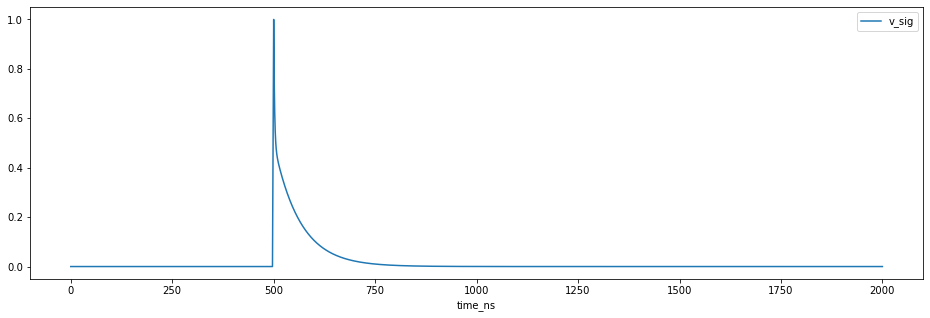

In [8]:
df_sig.plot(figsize=(16,5))

In [9]:
v_sig_FFT = np.fft.fft(df['v_sig'].values)
N_sig=len(v_sig_FFT)
N_fft=int(len(v_sig_FFT)/2)
unit_frequency=1.0/(df.index[-1]-df.index[0])/1.0e-9/1.0e6 # in MHz
print('N_sig = ',N_sig)
print('N_fft = ',N_fft)

N_sig =  8001
N_fft =  4000


In [10]:
frequency = unit_frequency*np.arange(0,N_fft)

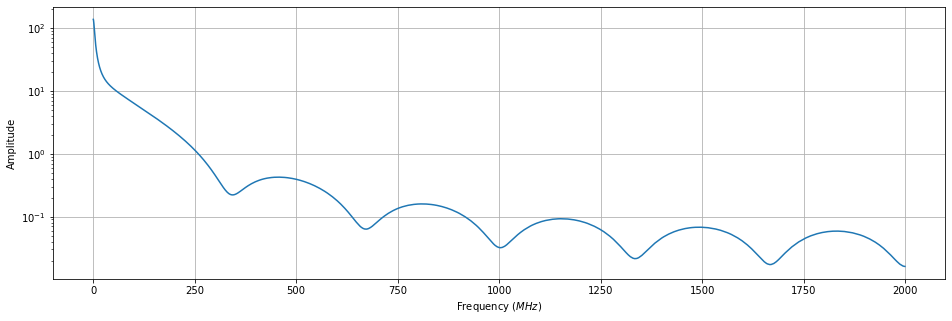

-35.47620539579013
51.03219364648181


In [11]:
fig, ax = plt.subplots(figsize=(16,5))
plt.yscale('log')
ax.plot(frequency[:N_fft], np.abs(v_sig_FFT[:N_fft]))
#ax.set_xlim(0, 2)
ax.set_xlabel('Frequency ($MHz$)')
ax.set_ylabel('Amplitude')
ax.grid(True)

#fig.tight_layout()
plt.show()

print(v_sig_FFT[10].real)
print(v_sig_FFT[10].imag)

In [12]:
tic = time.time()

cos_sin_df_l=[]

for k in range(0,N_fft):
    colname_cos = str('cos_' + str(k))
    colname_sin = str('sin_' + str(k))
    cos_df = pd.DataFrame(data=v_sig_FFT[k].real*np.cos(2*np.pi*k*df.index.values/dt_sig/N_sig),
                          index=df.index.values,
                          columns=[colname_cos])
    sin_df = pd.DataFrame(data=-v_sig_FFT[k].imag*np.sin(2*np.pi*k*df.index.values/dt_sig/N_sig),
                          index=df.index.values,
                          columns=[colname_sin])
    cos_sin_df_l.append(pd.concat([cos_df,sin_df],axis=1))
    #cos_l.append(v_sig_FFT[k].real*np.cos(2*np.pi*k*df.index/dt_sig/N_sig))
    #sin_l.append(-v_sig_FFT[k].imag*np.sin(2*np.pi*k*df.index/dt_sig/N_sig))

df=pd.concat(cos_sin_df_l,axis=1)
    
toc = time.time()
print('Execution time:', toc-tic, 'seconds')

Execution time: 2.734365224838257 seconds


In [13]:
df.head()

,cos_0,sin_0,cos_1,sin_1,cos_2,sin_2,cos_3,sin_3,cos_4,sin_4,...,cos_3995,sin_3995,cos_3996,sin_3996,cos_3997,sin_3997,cos_3998,sin_3998,cos_3999,sin_3999
0.00,137.999579,-0.0,-24.708766,0.000000,-120.210442,-0.000000,56.563987,-0.000000,87.788121,0.000000,...,-0.012146,-0.000000,0.010769,-0.000000,0.011879,0.00000,-0.011053,0.000000,-0.011581,-0.000000
0.25,137.999579,-0.0,-24.708758,0.104477,-120.210294,-0.069536,56.563830,-0.244758,87.787688,0.196207,...,0.012146,-0.000046,-0.010769,-0.000042,-0.011879,0.00003,0.011053,0.000023,0.011581,-0.000013
0.50,137.999579,-0.0,-24.708735,0.208954,-120.209849,-0.139073,56.563359,-0.489514,87.786389,0.392413,...,-0.012146,0.000092,0.010769,0.000085,0.011879,-0.00006,-0.011053,-0.000046,-0.011581,0.000026
0.75,137.999579,-0.0,-24.708697,0.313431,-120.209108,-0.208609,56.562574,-0.734268,87.784223,0.588614,...,0.012145,-0.000138,-0.010769,-0.000127,-0.011879,0.00009,0.011053,0.000069,0.011581,-0.000039
1.00,137.999579,-0.0,-24.708644,0.417908,-120.208070,-0.278144,56.561475,-0.979018,87.781191,0.784810,...,-0.012144,0.000184,0.010768,0.000170,0.011879,-0.00012,-0.011053,-0.000092,-0.011581,0.000053


<AxesSubplot:>

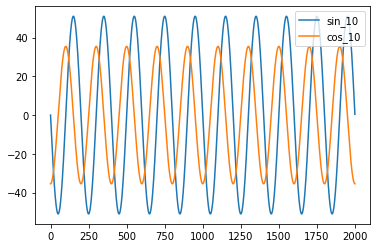

In [14]:
df[['sin_10','cos_10']].plot()

In [15]:
df_copy = df.copy()

In [16]:
df.reset_index(inplace=True,drop=True)

In [17]:
df

,cos_0,sin_0,cos_1,sin_1,cos_2,sin_2,cos_3,sin_3,cos_4,sin_4,...,cos_3995,sin_3995,cos_3996,sin_3996,cos_3997,sin_3997,cos_3998,sin_3998,cos_3999,sin_3999
0,137.999579,-0.0,-24.708766,0.000000,-120.210442,-0.000000,56.563987,-0.000000,87.788121,0.000000,...,-0.012146,-0.000000,0.010769,-0.000000,0.011879,0.00000,-0.011053,0.000000,-0.011581,-0.000000
1,137.999579,-0.0,-24.708758,0.104477,-120.210294,-0.069536,56.563830,-0.244758,87.787688,0.196207,...,0.012146,-0.000046,-0.010769,-0.000042,-0.011879,0.00003,0.011053,0.000023,0.011581,-0.000013
2,137.999579,-0.0,-24.708735,0.208954,-120.209849,-0.139073,56.563359,-0.489514,87.786389,0.392413,...,-0.012146,0.000092,0.010769,0.000085,0.011879,-0.00006,-0.011053,-0.000046,-0.011581,0.000026
3,137.999579,-0.0,-24.708697,0.313431,-120.209108,-0.208609,56.562574,-0.734268,87.784223,0.588614,...,0.012145,-0.000138,-0.010769,-0.000127,-0.011879,0.00009,0.011053,0.000069,0.011581,-0.000039
4,137.999579,-0.0,-24.708644,0.417908,-120.208070,-0.278144,56.561475,-0.979018,87.781191,0.784810,...,-0.012144,0.000184,0.010768,0.000170,0.011879,-0.00012,-0.011053,-0.000092,-0.011581,0.000053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7996,137.999579,-0.0,-24.708575,-0.522385,-120.206735,0.347679,56.560062,1.223762,87.777293,-0.980998,...,0.012143,0.000230,-0.010768,0.000212,-0.011878,-0.00015,0.011053,-0.000115,0.011581,0.000066
7997,137.999579,-0.0,-24.708644,-0.417908,-120.208070,0.278144,56.561475,0.979018,87.781191,-0.784810,...,-0.012144,-0.000184,0.010768,-0.000170,0.011879,0.00012,-0.011053,0.000092,-0.011581,-0.000053
7998,137.999579,-0.0,-24.708697,-0.313431,-120.209108,0.208609,56.562574,0.734268,87.784223,-0.588614,...,0.012145,0.000138,-0.010769,0.000127,-0.011879,-0.00009,0.011053,-0.000069,0.011581,0.000039
7999,137.999579,-0.0,-24.708735,-0.208954,-120.209849,0.139073,56.563359,0.489514,87.786389,-0.392413,...,-0.012146,-0.000092,0.010769,-0.000085,0.011879,0.00006,-0.011053,0.000046,-0.011581,-0.000026


In [18]:
df_t=df.transpose()

In [19]:
df_t.head()

,0,1,2,3,4,5,6,7,8,9,...,7991,7992,7993,7994,7995,7996,7997,7998,7999,8000
cos_0,137.999579,137.999579,137.999579,137.999579,137.999579,137.999579,137.999579,137.999579,137.999579,137.999579,...,137.999579,137.999579,137.999579,137.999579,137.999579,137.999579,137.999579,137.999579,137.999579,137.999579
sin_0,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
cos_1,-24.708766,-24.708758,-24.708735,-24.708697,-24.708644,-24.708575,-24.708492,-24.708393,-24.708278,-24.708149,...,-24.708004,-24.708149,-24.708278,-24.708393,-24.708492,-24.708575,-24.708644,-24.708697,-24.708735,-24.708758
sin_1,0.000000,0.104477,0.208954,0.313431,0.417908,0.522385,0.626861,0.731337,0.835812,0.940287,...,-1.044761,-0.940287,-0.835812,-0.731337,-0.626861,-0.522385,-0.417908,-0.313431,-0.208954,-0.104477
cos_2,-120.210442,-120.210294,-120.209849,-120.209108,-120.208070,-120.206735,-120.205104,-120.203177,-120.200953,-120.198433,...,-120.195616,-120.198433,-120.200953,-120.203177,-120.205104,-120.206735,-120.208070,-120.209108,-120.209849,-120.210294


<AxesSubplot:>

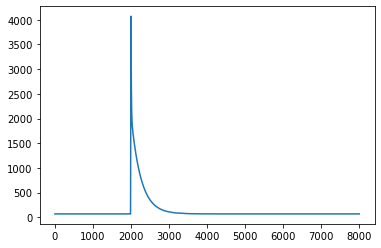

In [20]:
df_t.sum(axis=0).plot()

In [24]:
preamp_min_bp = 0;  # MHz
preamp_max_bp = 20; # MHz
preamp_min_bp_ind = int(preamp_min_bp/dt_sig)
preamp_max_bp_ind = int(preamp_max_bp/dt_sig)
#
df_sig_filter = df.transpose()[preamp_min_bp_ind:preamp_max_bp_ind].sum(axis=0)
#
sig_filter_time = df_sig_filter.index*dt_sig
sig_filter_amplitude = df_sig_filter.values-np.mean(df_sig_filter.values[:100])
sig_filter_amplitude = sig_filter_amplitude/float(sig_filter_amplitude.sum()*sig_time_window_width)*charge
#sig_time_window_width = (df_sig.index[-1]-df_sig.index[0])
#charge=float(df_sig.sum()*sig_time_window_width)

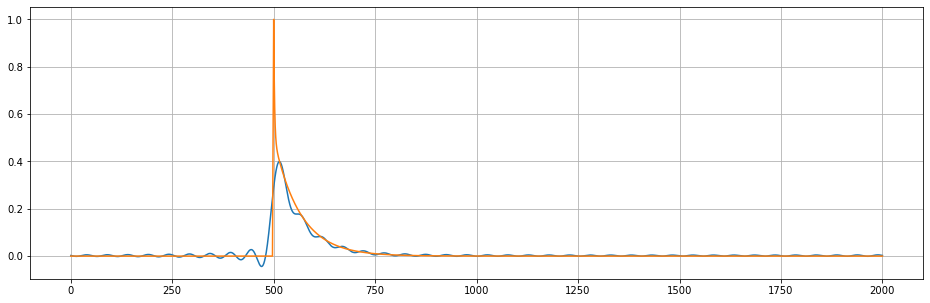

In [25]:
#plt.plot(sig_filter_time,sig_filter_amplitude)
#df_sig.plot()
fig, ax2 = plt.subplots(figsize=(16,5))
#plt.yscale('log')
ax2.plot(sig_filter_time,sig_filter_amplitude)
ax2.plot(df_sig.index,df_sig.values)
#ax2.set_xlim(0, 2)
#ax2.set_xlabel('Frequency ($MHz$)')
#ax2.set_ylabel('Amplitude')
ax2.grid(True)

#fig.tight_layout()
plt.show()

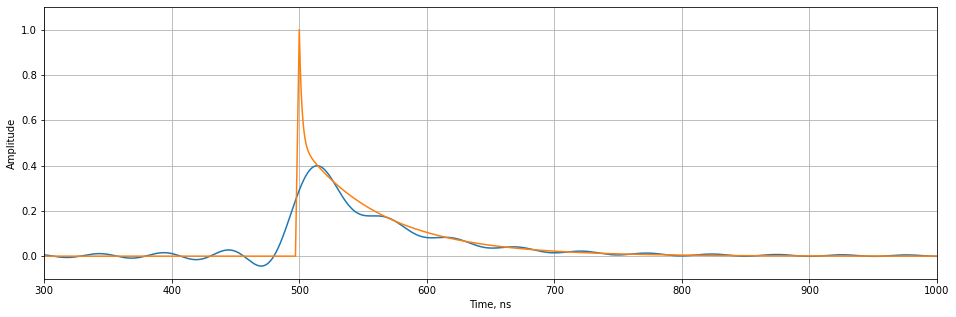

In [30]:
#plt.plot(sig_filter_time,sig_filter_amplitude)
#df_sig.plot()
fig, ax2 = plt.subplots(figsize=(16,5))
#plt.yscale('log')
ax2.plot(sig_filter_time,sig_filter_amplitude)
ax2.plot(df_sig.index,df_sig.values)
ax2.set_xlim(300, 1000)
ax2.set_ylim(-0.1, 1.1)
ax2.set_xlabel('Time, ns')
ax2.set_ylabel('Amplitude')
ax2.grid(True)

#fig.tight_layout()
plt.show()